In [1]:
import pandas as pd
from numpy import mean
import numpy as np
from tqdm import tqdm

#Sklearn 
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

#AI360 
from fairlearn.metrics import MetricFrame
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.sklearn.metrics import equal_opportunity_difference
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.lfr import LFR

# Graphs libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

from IPython.display import Markdown, display
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools



In [2]:
# define dataset
data = pd.read_csv('dataset_ready2.csv') 
data = data.set_index('ORG_org_uuid')

#More cleaning
data = data.drop(['Unnamed: 0'], axis = 1)
data_orig = data.copy()
data = data.query('unknown_founders == 0 and female_founders != 0 or male_founders != 0')

data = data.drop(data[data.total_num_founders > 10].index)
data = data.drop(data[data.status == 'operating'].index)


In [3]:
cols_to_drop = ['company_name', 'category_list', 'category_group_list',
               'region', 'city', 'homepage_url', 'founded_on']
data.drop(columns = cols_to_drop, inplace = True)
#data_bef_scale = data.copy()

In [4]:
## CREATE A BINARY OUTCOME VARIABLE
data.replace('ipo', 1, regex = True, inplace = True)
data.replace('acquired', 1, regex = True, inplace = True)
data.replace('closed', 0, regex = True, inplace = True)

In [39]:
data.describe()

,city_success_ranking,region_rank,multiple_degrees_sum,multiple_degrees_average,is_completed_sum,is_completed_avg,work_experience_avg,work_experience_sum,education_time_avg,education_time_sum,...,female_founders,unknown_founders,total_num_founders,category_list1,category_list2,category_list3,category_group_list1,category_group_list2,category_group_list3,mostly_male_founders
count,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,...,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000
mean,0.651549,0.509259,0.539178,0.212246,0.539178,0.212246,611.411528,1332.396653,172.355784,357.518601,...,0.346943,0.074782,2.849461,210.234635,267.830942,11614.014025,14.749066,17.853631,2837.484486,0.894515
std,0.203345,0.274021,1.194603,0.385516,1.194603,0.385516,1579.023639,4016.656463,477.379581,1163.146205,...,0.759008,0.313573,2.200813,182.320013,215.108440,10496.298272,11.089382,14.197802,3048.394629,0.307186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5133.000000,-16438.000000,-9131.000000,-9131.000000,...,0.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.660886,0.406250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,54.000000,21.000000,-1.000000,5.000000,-1.000000,-1.000000,1.000000
50%,0.690277,0.619048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,187.000000,257.000000,13362.000000,14.000000,21.000000,-1.000000,1.000000
75%,0.733528,0.716518,1.000000,0.200000,1.000000,0.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.000000,329.000000,420.000000,22792.000000,23.000000,27.000000,6411.000000,1.000000
max,1.000000,1.000000,10.000000,1.000000,10.000000,1.000000,12695.000000,70438.000000,9496.000000,13514.000000,...,9.000000,6.000000,10.000000,706.000000,715.000000,25325.000000,42.000000,44.000000,6671.000000,1.000000


### Transform to AIF360 compatible data 

In [5]:
privileged_groups = [{'mostly_male_founders': 1}]
unprivileged_groups = [{'mostly_male_founders': 0}]

dataset_orig = StandardDataset(data, 
                          label_name='status', 
                          favorable_classes=[1], 
                          protected_attribute_names=['mostly_male_founders'], 
                          privileged_classes=[[1]])

### Split into train, validation and test

In [6]:
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.75], shuffle=True, seed = 10)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.2], shuffle=True, seed = 10)


In [7]:
#help(StandardDataset.split)

In [8]:
#%%script false --no-raise-error
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print(dataset_orig_test.features.shape, "\n Percent of total %.2f" % (dataset_orig_test.features.shape[0]/
                                                             (dataset_orig.features.shape[0])*100), "%")
display(Markdown("#### Validation Dataset shape"))
print(dataset_orig_valid.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(13850, 21)


#### Test Dataset shape

(3694, 21) 
 Percent of total 20.00 %


#### Validation Dataset shape

(923, 21)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['mostly_male_founders']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['city_success_ranking', 'region_rank', 'multiple_degrees_sum', 'multiple_degrees_average', 'is_completed_sum', 'is_completed_avg', 'work_experience_avg', 'work_experience_sum', 'education_time_avg', 'education_time_sum', 'male_founders', 'female_founders', 'unknown_founders', 'total_num_founders', 'category_list1', 'category_list2', 'category_list3', 'category_group_list1', 'category_group_list2', 'category_group_list3', 'mostly_male_founders']


### Metric for the original training data

In [9]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes = %f" % metric_orig_train.mean_difference())
print("Disparate Impact = %f" %metric_orig_train.disparate_impact())


#print("Number of negatives male founders = %2.f" %metric_orig_train.num_negatives(privileged = True))
#print("Number of negatives female founders = %2.f" %metric_orig_train.num_negatives(privileged = False))
#print("Number of positives male founders = %2.f" %metric_orig_train.num_positives(privileged = True))
#print("Number of positives female founders = %2.f" %metric_orig_train.num_positives(privileged = False))

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes = %f" % metric_orig_test.mean_difference())
print("Disparate Impact = %f" %metric_orig_test.disparate_impact())


#print("Number of negatives male founders = %2.f" %metric_orig_test.num_negatives(privileged = True))
#print("Number of negatives female founders = %2.f" %metric_orig_test.num_negatives(privileged = False))
#print("Number of positives male founders = %2.f" %metric_orig_test.num_positives(privileged = True))
#print("Number of positives female founders = %2.f" %metric_orig_test.num_positives(privileged = False))

#### Original training dataset

Difference in mean outcomes = -0.074371
Disparate Impact = 0.898739


#### Original test dataset

Difference in mean outcomes = -0.076516
Disparate Impact = 0.896921


In [ ]:

male_frame = data.query('mostly_male_founders == 1')
male_frame_desc = male_frame.describe()

male_frame_fail = male_frame.query('status == 0').describe()
male_frame_succ = male_frame.query('status == 1').describe()

female_frame = data.query('mostly_male_founders == 0')
female_frame_desc = female_frame.describe()
female_frame_fail = female_frame.query('status == 0').describe()
female_frame_succ = female_frame.query('status == 1').describe()

Feature: 0, Score: 0.37779
Feature: 1, Score: 0.52970
Feature: 2, Score: 0.02940
Feature: 3, Score: -0.03378
Feature: 4, Score: 0.02940
Feature: 5, Score: -0.03378
Feature: 6, Score: 0.15726
Feature: 7, Score: -0.29927
Feature: 8, Score: 0.04595
Feature: 9, Score: 0.44654
Feature: 10, Score: 0.26914
Feature: 11, Score: 0.03278
Feature: 12, Score: -0.06379
Feature: 13, Score: 0.23943
Feature: 14, Score: -0.04229
Feature: 15, Score: -0.06383
Feature: 16, Score: 0.19342
Feature: 17, Score: 0.17185
Feature: 18, Score: 0.09225
Feature: 19, Score: 0.00130
Feature: 20, Score: -0.07194


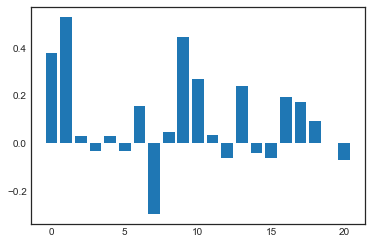

In [32]:
importance = lmod.coef_[0]

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [72]:
data_x = data.drop('status', axis = 1)

In [73]:
importances = pd.DataFrame(data={
    'Attribute': data_x.columns,
    'Importance': lmod.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)



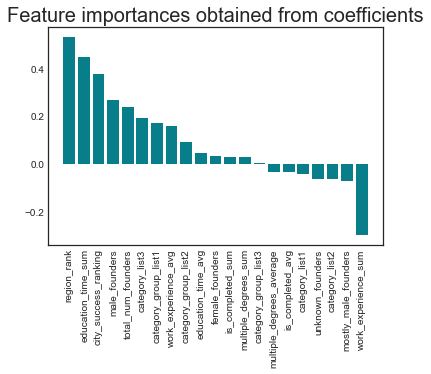

In [74]:

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()